# step 1

#### Import necessary libraries 

#### Read dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report

In [3]:

data = pd.read_csv("drug200.csv.xls")

X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Labels

print("Unique values before factorization:", y.unique())

# Factorize 'y'
y, mapping = pd.factorize(y)

# Print the mapping between string values and integer values
print("Mapping:")
for index, value in enumerate(mapping):
    print(f"'{value}' --> {index}")




Unique values before factorization: ['DrugY' 'drugC' 'drugX' 'drugA' 'drugB']
Mapping:
'DrugY' --> 0
'drugC' --> 1
'drugX' --> 2
'drugA' --> 3
'drugB' --> 4


# step 2

#### Convert categorical values into numeric values

In [6]:


# Encode the categorical features: Sex, BP, and Cholesterol
categorical_features = ["Sex", "BP", "Cholesterol"]
encoder = LabelEncoder()

for feature in categorical_features:
    X[feature] = encoder.fit_transform(X[feature])
    



# step 3

#### Apply PCA to the given data and reduce the number of features to 3.

#### PCA

PCA is a linear dimensionality reduction technique that aims to find the directions (principal components) in the feature space that explain the maximum variance in the data.

The aim of PCA is to transform a high-dimensional dataset into a lower-dimensional space while preserving the most important information or patterns in the data.

The resulting principal components represent new features that are a linear combination of the original features.

In [7]:

# Apply PCA and reduce the number of features to 3
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Compute the total variation explained by the first 3 principal components
total_variation = sum(pca.explained_variance_ratio_) * 100
print("Total variation explained:", total_variation)


Total variation explained: 99.85111868497313


'DrugY' --> 0

'drugC' --> 1

'drugX' --> 2

'drugA' --> 3

'drugB' --> 4

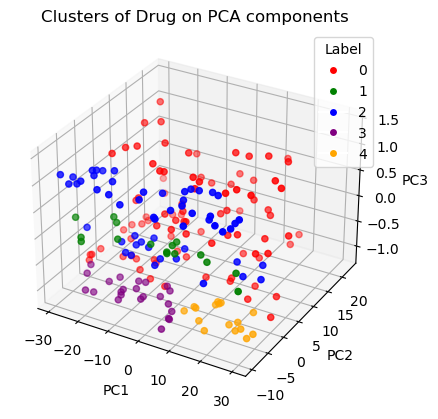

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
custom_colors = ['red', 'green', 'blue', 'purple', 'orange']
cmap = mcolors.ListedColormap(custom_colors)
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap=cmap)

# Set labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Clusters of Drug on PCA components')


unique_labels = sorted(set(y))
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color)
                   for label, color in zip(unique_labels, custom_colors)]
plt.legend(handles=legend_elements, title='Label')
plt.show()



#### Split the data into training and testing sets

In [13]:
# Split the data into training and testing sets
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.4, random_state=42)
print("Training data shape:", X_train_pca.shape, y_train.shape)
print("Testing data shape:", X_test_pca.shape, y_test.shape)

Training data shape: (120, 3) (120,)
Testing data shape: (80, 3) (80,)


# step 4

#### Write down the logistic regression objective function with the L1 penalty term

In [14]:
def objective(A, b, mu, x, z):
    m = A.shape[0]
    obj = np.sum(np.log(1 + np.exp(-A @ x[1:] - b * x[0]))) + m * mu * np.linalg.norm(z, 1)
    return obj

# step 5

#### Optimize the objective function by the ADMM algorithm.

https://web.stanford.edu/~boyd/papers/admm/logreg-l1/logreg.html

In [15]:

# logreg   Solve L1 regularized logistic regression via ADMM

# logreg(A, b, mu, rho, alpha) solves the following problem via ADMM:

# minimize   sum( log(1 + exp(-b_i*(a_i'w + v)) ) + m*mu*norm(w,1)

# where A is a feature matrix and b is a response vector. The scalar m is the number of examples in the matrix A.

# This solves the L1 regularized logistic regression problem. It uses a custom Newton solver for the x-step.

# The solution is returned in the vector x = (v,w).

# rho is the augmented Lagrangian parameter.

# alpha is the over-relaxation parameter (typical values for alpha are between 1.0 and 1.8).

def logreg(A, b, mu, rho, alpha):
    # Global constants and defaults
    QUIET = 0
    MAX_ITER = 1000
    ABSTOL = 1e-4
    RELTOL = 1e-2
    
    # Data preprocessing
    m, n = A.shape
    
    # ADMM solver
    x = np.zeros(n + 1)
    z = np.zeros(n + 1)
    u = np.zeros(n + 1)
    
    if not QUIET:
        print('%3s\t%10s\t%10s\t%10s\t%10s\t%10s' % ('iter', 'r norm', 'eps pri', 's norm', 'eps dual', 'objective'))
    
    for k in range(MAX_ITER):
        # x-update
        x = update_x(A, b, u, z, rho)
    
        # z-update with relaxation
        zold = z
        x_hat = alpha * x + (1 - alpha) * zold
        z = x_hat + u
        z[1:] = shrinkage(z[1:], (m * mu) / rho)
    
        u = u + (x_hat - z)
    
        # diagnostics, reporting, termination checks
        # The below part contains the objective value, the primal and dual residual norms,
            # and the tolerances for the primal and dual residual norms at each iteration.
        objval = objective(A, b, mu, x, z)
        r_norm = np.linalg.norm(x - z)
        s_norm = np.linalg.norm(rho * (z - zold))
    
        eps_pri = np.sqrt(n) * ABSTOL + RELTOL * max(np.linalg.norm(x), np.linalg.norm(z))
        eps_dual = np.sqrt(n) * ABSTOL + RELTOL * np.linalg.norm(rho * u)
    
        if not QUIET:
            print('%3d\t%10.4f\t%10.4f\t%10.4f\t%10.4f\t%10.2f' % (k, r_norm, eps_pri, s_norm, eps_dual, objval))
    
        if r_norm < eps_pri and s_norm < eps_dual:
            break
    
    return z



def update_x(A, b, u, z, rho, x0=None):
    
    # solve the x update
    # minimize [ -logistic(x_i) + (rho/2) * ||x_i - z^k + u^k||^2  ]
    # via Newton's method; for a single subsystem only.
    
    alpha = 0.1
    BETA = 0.5
    TOLERANCE = 1e-5
    MAX_ITER = 50
    
    m, n = A.shape
    I = np.eye(n + 1)
    
    if x0 is not None:
        x = x0.copy()
    else:
        x = np.zeros(n + 1)
    
    C = np.concatenate((-b[:, np.newaxis], -A), axis=1)
    f = lambda w: np.sum(np.log(1 + np.exp(C @ w))) + (rho / 2) * np.linalg.norm(w - z + u) ** 2
    
    for _ in range(MAX_ITER):
        fx = f(x)
        g = C.T @ (np.exp(C @ x) / (1 + np.exp(C @ x))) + rho * (x - z + u)
        H = C.T @ np.diag(np.exp(C @ x) / (1 + np.exp(C @ x)) ** 2) @ C + rho * I
        dx = -np.linalg.solve(H, g)  # Newton step
        dfx = g.dot(dx)  # Newton decrement
        
        if np.abs(dfx) < TOLERANCE:
            break
        
        # backtracking
        t = 1
        while f(x + t * dx) > fx + alpha * t * dfx:
            t = BETA * t
        x = x + t * dx
    
    return x

def shrinkage(a, kappa):
    return np.maximum(0, a - kappa) - np.maximum(0, -a - kappa)


# step 6

#### Find an optimal penalty parameter mu for the objective function

In [16]:


# Define the mu parameter grid
penalty_params = [1, 0.1, 0.01, 0.001]

# Perform grid search with cross-validation
model = LogisticRegressionCV(Cs=penalty_params, cv=5, penalty='l1', solver='liblinear')
model.fit(X_train_pca, y_train)

# Get the best penalty mu parameter
best_penalty = model.C_[0]
print("Best penalty parameter:", best_penalty)


Best penalty parameter: 1.0


# step 7

#### Classify your testing samples

In [17]:
# Apply logreg function to get the weights of the model
# use mu comes from grid search with cross validation

mu = 1.0  # Regularization parameter
rho = 1.0  # Augmented Lagrangian parameter
alpha = 1.0  # Over-relaxation parameter

# Determine the number of classes
num_classes = np.unique(y_train).shape[0]

# Train multiple logistic regression models (one-vs-all)
models = []
for i in range(num_classes):
    # Create a multi label vector for the current class
    y_train_multi = np.where(y_train == i, 1, 0)
    
    # Train the logistic regression model using logreg function
    weights = logreg(X_train_pca, y_train_multi, mu, rho, alpha)
    
    # Save the trained model
    models.append(weights)

# Make predictions on the testing samples
y_pred_probabilities = np.zeros((X_test_pca.shape[0], num_classes))
for i in range(num_classes):
    weights = models[i]
    y_pred_probabilities[:, i] = 1 / (1 + np.exp(-(X_test_pca @ weights[1:] + weights[0])))

# Assign the class label with the highest probability as the predicted class
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Calculate accuracy
accuracy = (y_pred == y_test).mean()
print("Accuracy:", accuracy)


iter	    r norm	   eps pri	    s norm	  eps dual	 objective
  0	    0.2596	    0.0469	    4.6660	    0.0028	    582.79
  1	    0.3625	    0.0712	    2.4307	    0.0064	    866.21
  2	    0.4252	    0.0880	    1.6707	    0.0106	   1063.28
  3	    0.4717	    0.1007	    1.2774	    0.0153	   1214.64
  4	    0.5096	    0.1110	    1.0310	    0.0203	   1337.12
  5	    0.5413	    0.1196	    0.8585	    0.0257	   1439.26
  6	    0.5678	    0.1269	    0.7284	    0.0313	   1526.02
  7	    0.5899	    0.1332	    0.6252	    0.0371	   1600.55
  8	    0.6080	    0.1386	    0.5403	    0.0431	   1665.00
  9	    0.6226	    0.1433	    0.4684	    0.0493	   1720.91
 10	    0.6341	    0.1473	    0.4065	    0.0556	   1769.45
 11	    0.6426	    0.1509	    0.3535	    0.0620	   1811.69
 12	    0.6488	    0.1539	    0.3059	    0.0685	   1848.26
 13	    0.6529	    0.1566	    0.2638	    0.0750	   1879.81
 14	    0.6550	    0.1588	    0.2264	    0.0815	   1906.91
 15	    0.6552	    0.1608	    0.1932	    0.0881	   1930

199	    0.2136	    0.1706	    0.0000	    0.7194	   2064.41
200	    0.2129	    0.1706	    0.0000	    0.7215	   2064.46
201	    0.2122	    0.1706	    0.0000	    0.7236	   2064.51
202	    0.2115	    0.1706	    0.0000	    0.7257	   2064.57
203	    0.2108	    0.1706	    0.0000	    0.7278	   2064.62
204	    0.2101	    0.1706	    0.0000	    0.7299	   2064.67
205	    0.2094	    0.1706	    0.0000	    0.7320	   2064.73
206	    0.2088	    0.1706	    0.0000	    0.7341	   2064.78
207	    0.2081	    0.1706	    0.0000	    0.7362	   2064.83
208	    0.2074	    0.1706	    0.0000	    0.7383	   2064.88
209	    0.2067	    0.1706	    0.0000	    0.7403	   2064.94
210	    0.2060	    0.1706	    0.0000	    0.7424	   2064.99
211	    0.2054	    0.1706	    0.0000	    0.7444	   2065.04
212	    0.2047	    0.1706	    0.0000	    0.7465	   2065.09
213	    0.2041	    0.1706	    0.0000	    0.7485	   2065.14
214	    0.2034	    0.1706	    0.0000	    0.7506	   2065.19
215	    0.2027	    0.1706	    0.0000	    0.7526	   2065.

# step 8

#### Determine the confusion matrix and calculate the overall accuracy, class accuracies, sensitivity, specificity and recall values


In [18]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate classification report with accuracy, class accuracies, sensitivity, specificity, and recall values
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


Confusion Matrix:
[[33  0  0  0  0]
 [ 6  0  0  0  0]
 [25  0  0  0  0]
 [10  0  0  0  0]
 [ 6  0  0  0  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.41      1.00      0.58        33
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        25
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         6

    accuracy                           0.41        80
   macro avg       0.08      0.20      0.12        80
weighted avg       0.17      0.41      0.24        80



/Users/bernayilmaz/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bernayilmaz/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bernayilmaz/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# step 9

#### Apply Non-negative Matrix Factorization

NMF is a linear dimensionality reduction technique that factorizes the input matrix into two lower-rank matrices, typically representing the latent features and their corresponding coefficients.

NMF aims to find a non-negative factorization of the data, which can be particularly useful for data with non-negative values or when non-negativity constraints are desired.


In [21]:

def NMF(V, r, threshold, max_iterations):
    
    # r rank 
    m, n = V.shape
    
    # Initialize W and H with random values
    W = np.random.rand(m, r)
    H = np.random.rand(r, n)
    
    e = 1.0e-8 # Small value for numerical stability
    
    for i in range(max_iterations):
        
        # Store previous values of H and W for difference calculation
        H_prev = H.copy()
        W_prev = W.copy()
        
        # Update H
        numerator = np.dot(np.transpose(W), V)
        denominator = np.dot(np.dot(np.transpose(W), W), H) + e
        H *= numerator / denominator
        
        # Update W
        numerator = np.dot(V, np.transpose(H))
        denominator = np.dot(W, np.dot(H, np.transpose(H))) + e
        W *= numerator / denominator
        
        # Calculate the difference between consecutive iterations
        diff_H = np.linalg.norm(H - H_prev)
        diff_W = np.linalg.norm(W - W_prev)
        
        # Check the stopping criterion
        if diff_H < threshold and diff_W < threshold:
            break
        
    return W, H


r = 3 
threshold = 0.0001
max_iterations = 1000

W, H = NMF(X, r, threshold, max_iterations)



In [22]:
print("Feature matrix W:")
print(W)


Feature matrix W:
[[1.17606593e-01 1.44134229e+00 2.79225128e-01]
 [4.57346684e-01 5.15438100e-01 6.84572625e-01]
 [2.96588256e-01 3.14297232e-01 7.60793738e-01]
 [1.18915074e+00 3.80289774e-01 5.96499654e-02]
 [1.00520691e+00 7.67680436e-01 7.26355418e-01]
 [3.49232790e-01 4.09395789e-01 2.56799131e-01]
 [4.91805373e-01 7.04832649e-01 6.94748498e-01]
 [8.10434747e-01 4.58134665e-01 4.42713382e-01]
 [8.03698209e-01 5.78219342e-01 7.98268770e-01]
 [7.98386134e-02 9.12717536e-01 7.17702312e-01]
 [1.25339694e+00 4.94708992e-01 3.88415932e-01]
 [4.57294581e-01 9.98242545e-01 3.97598212e-01]
 [2.16928979e-01 6.70409086e-01 6.85752549e-01]
 [3.05520712e+00 1.01743765e+00 1.87720624e-01]
 [4.95631281e-01 4.71856429e-01 7.31055939e-01]
 [8.55997907e-02 8.69625836e-01 2.03591791e-01]
 [6.49361595e-01 2.64334868e-01 1.05260432e+00]
 [5.24351805e-01 6.05554156e-01 5.75731982e-01]
 [3.06039590e-01 3.15462378e-01 2.99427328e-01]
 [3.99287594e-01 1.43682661e+00 3.46000617e-01]
 [1.34085767e+00 8.937

In [23]:
print("Observation matrix H:")
print(H)

Observation matrix H:
[[19.59608315  0.17562766  0.43076742  0.08144101  1.04100109]
 [ 4.1951655   0.10814223  0.22954529  0.24578039 16.30517458]
 [52.41356788  0.53165749  0.69655032  0.38814219  6.15071783]]


In [25]:
X_nmf = np.dot(W, H)
# Split the data into training and testing sets
X_train_nmf, X_test_nmf, y_train, y_test = train_test_split(X_nmf, y, test_size=0.4, random_state=42)
print("Training data shape:", X_train_nmf.shape, y_train.shape)
print("Testing data shape:", X_test_nmf.shape, y_test.shape)

Training data shape: (120, 5) (120,)
Testing data shape: (80, 5) (80,)


In [26]:
# Define the mu parameter grid
penalty_params = [1, 0.1, 0.01, 0.001]

# Perform grid search with cross-validation
model = LogisticRegressionCV(Cs=penalty_params, cv=5, penalty='l1', solver='liblinear')
model.fit(X_train_nmf, y_train)

# Get the best penalty parameter
best_penalty = model.C_[0]
print("Best penalty parameter:", best_penalty)

Best penalty parameter: 1.0


##### 1. Apply logreg function to get the weights of the model
##### 2. Train multiple logistic regression models (one-vs-all)
##### 3. Use the encoding coefficients as features for samples
##### 4. Make predictions on the testing samples
##### 5. Calculate accuracy

In [27]:
# Apply logreg function to get the weights of the model
# use mu comes from grid search with cross validation
# Use the encoding coefficients as features for samples

mu = 1.0  # Regularization parameter
rho = 1.0  # Augmented Lagrangian parameter
alpha = 1.0  # Over-relaxation parameter

# Determine the number of classes
num_classes = np.unique(y_train).shape[0]

# Train multiple logistic regression models (one-vs-all)
models = []
for i in range(num_classes):
    # Create a multi label vector for the current class
    y_train_multi = np.where(y_train == i, 1, 0)
    
    # the logistic regression model using logreg function
    weights = logreg(X_train_nmf, y_train_multi, mu, rho, alpha)
    
    # Save the trained model
    models.append(weights)

# Make predictions on the testing samples
y_pred_probabilities = np.zeros((X_test_nmf.shape[0], num_classes))
for i in range(num_classes):
    weights = models[i]
    y_pred_probabilities[:, i] = 1 / (1 + np.exp(-(X_test_nmf @ weights[1:] + weights[0])))

# Assign the class label with the highest probability as the predicted class
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Calculate accuracy
accuracy = (y_pred == y_test).mean()
print("Accuracy:", accuracy)


iter	    r norm	   eps pri	    s norm	  eps dual	 objective
  0	    0.3065	    0.0033	    0.0032	    0.0033	      0.39
  1	    0.2788	    0.0030	    0.0063	    0.0061	      1.16
  2	    0.2631	    0.0029	    0.0093	    0.0087	      2.29
  3	    0.2518	    0.0028	    0.0122	    0.0112	      3.77
  4	    0.2436	    0.0027	    0.0150	    0.0137	      5.58
  5	    0.2369	    0.0027	    0.0176	    0.0160	      7.71
  6	    0.2312	    0.0027	    0.0201	    0.0183	     10.13
  7	    0.2262	    0.0027	    0.0225	    0.0206	     12.85
  8	    0.2219	    0.0028	    0.0248	    0.0228	     15.83
  9	    0.2180	    0.0029	    0.0269	    0.0250	     19.07
 10	    0.2144	    0.0031	    0.0289	    0.0271	     22.55
 11	    0.2111	    0.0033	    0.0308	    0.0293	     26.25
 12	    0.2081	    0.0035	    0.0326	    0.0313	     30.17
 13	    0.2052	    0.0037	    0.0342	    0.0334	     34.28
 14	    0.2023	    0.0040	    0.0357	    0.0354	     38.56
 15	    0.1999	    0.0043	    0.0371	    0.0374	     43

160	    0.1193	    0.0404	    0.0117	    0.2433	    482.75
161	    0.1191	    0.0405	    0.0116	    0.2445	    484.15
162	    0.1190	    0.0406	    0.0116	    0.2457	    485.54
163	    0.1188	    0.0407	    0.0115	    0.2468	    486.93
164	    0.1186	    0.0409	    0.0114	    0.2480	    488.30
165	    0.1185	    0.0410	    0.0114	    0.2492	    489.67
166	    0.1183	    0.0411	    0.0113	    0.2504	    491.02
167	    0.1181	    0.0412	    0.0112	    0.2516	    492.37
168	    0.1180	    0.0413	    0.0111	    0.2528	    493.72
169	    0.1178	    0.0414	    0.0111	    0.2539	    495.05
170	    0.1177	    0.0415	    0.0110	    0.2551	    496.37
171	    0.1175	    0.0416	    0.0109	    0.2563	    497.69
172	    0.1174	    0.0417	    0.0109	    0.2575	    499.00
173	    0.1172	    0.0419	    0.0108	    0.2586	    500.30
174	    0.1170	    0.0420	    0.0107	    0.2598	    501.59
175	    0.1169	    0.0421	    0.0107	    0.2610	    502.88
176	    0.1167	    0.0422	    0.0106	    0.2621	    504.

368	    0.0980	    0.0558	    0.0050	    0.4656	    667.95
369	    0.0979	    0.0558	    0.0050	    0.4665	    668.54
370	    0.0979	    0.0559	    0.0049	    0.4675	    669.14
371	    0.0978	    0.0559	    0.0049	    0.4685	    669.73
372	    0.0978	    0.0560	    0.0049	    0.4695	    670.33
373	    0.0977	    0.0560	    0.0049	    0.4704	    670.92
374	    0.0976	    0.0561	    0.0049	    0.4714	    671.51
375	    0.0976	    0.0561	    0.0049	    0.4724	    672.09
376	    0.0975	    0.0562	    0.0049	    0.4734	    672.68
377	    0.0974	    0.0562	    0.0048	    0.4743	    673.26
378	    0.0974	    0.0562	    0.0048	    0.4753	    673.85
379	    0.0973	    0.0563	    0.0048	    0.4763	    674.43
380	    0.0972	    0.0563	    0.0048	    0.4773	    675.01
381	    0.0972	    0.0564	    0.0048	    0.4782	    675.59
382	    0.0971	    0.0564	    0.0048	    0.4792	    676.16
383	    0.0970	    0.0565	    0.0048	    0.4802	    676.74
384	    0.0970	    0.0565	    0.0048	    0.4811	    677.

576	    0.0874	    0.0639	    0.0031	    0.6573	    766.10
577	    0.0874	    0.0639	    0.0031	    0.6581	    766.48
578	    0.0873	    0.0640	    0.0031	    0.6590	    766.86
579	    0.0873	    0.0640	    0.0031	    0.6599	    767.23
580	    0.0872	    0.0640	    0.0031	    0.6607	    767.61
581	    0.0872	    0.0640	    0.0031	    0.6616	    767.99
582	    0.0872	    0.0641	    0.0031	    0.6625	    768.36
583	    0.0871	    0.0641	    0.0031	    0.6634	    768.73
584	    0.0871	    0.0641	    0.0031	    0.6642	    769.11
585	    0.0871	    0.0642	    0.0031	    0.6651	    769.48
586	    0.0870	    0.0642	    0.0031	    0.6660	    769.85
587	    0.0870	    0.0642	    0.0031	    0.6668	    770.22
588	    0.0869	    0.0643	    0.0031	    0.6677	    770.60
589	    0.0869	    0.0643	    0.0031	    0.6686	    770.97
590	    0.0869	    0.0643	    0.0031	    0.6694	    771.34
591	    0.0868	    0.0644	    0.0031	    0.6703	    771.70
592	    0.0868	    0.0644	    0.0030	    0.6712	    772.

754	    0.0813	    0.0687	    0.0024	    0.8070	    824.65
755	    0.0813	    0.0688	    0.0024	    0.8078	    824.94
756	    0.0812	    0.0688	    0.0024	    0.8086	    825.22
757	    0.0812	    0.0688	    0.0024	    0.8094	    825.51
758	    0.0812	    0.0688	    0.0024	    0.8102	    825.80
759	    0.0812	    0.0688	    0.0024	    0.8110	    826.08
760	    0.0811	    0.0689	    0.0024	    0.8118	    826.37
761	    0.0811	    0.0689	    0.0024	    0.8127	    826.65
762	    0.0811	    0.0689	    0.0024	    0.8135	    826.94
763	    0.0810	    0.0689	    0.0023	    0.8143	    827.22
764	    0.0810	    0.0690	    0.0023	    0.8151	    827.51
765	    0.0810	    0.0690	    0.0023	    0.8159	    827.79
766	    0.0809	    0.0690	    0.0023	    0.8167	    828.07
767	    0.0809	    0.0690	    0.0023	    0.8175	    828.36
768	    0.0809	    0.0691	    0.0023	    0.8183	    828.64
769	    0.0809	    0.0691	    0.0023	    0.8191	    828.92
770	    0.0808	    0.0691	    0.0023	    0.8199	    829.

940	    0.0764	    0.0727	    0.0019	    0.9534	    872.34
941	    0.0764	    0.0727	    0.0019	    0.9541	    872.57
942	    0.0764	    0.0727	    0.0019	    0.9549	    872.80
943	    0.0764	    0.0727	    0.0019	    0.9556	    873.03
944	    0.0764	    0.0727	    0.0019	    0.9564	    873.26
945	    0.0763	    0.0728	    0.0019	    0.9572	    873.49
946	    0.0763	    0.0728	    0.0019	    0.9579	    873.72
947	    0.0763	    0.0728	    0.0019	    0.9587	    873.95
948	    0.0763	    0.0728	    0.0019	    0.9595	    874.17
949	    0.0762	    0.0728	    0.0019	    0.9602	    874.40
950	    0.0762	    0.0729	    0.0019	    0.9610	    874.63
951	    0.0762	    0.0729	    0.0019	    0.9617	    874.86
952	    0.0762	    0.0729	    0.0019	    0.9625	    875.08
953	    0.0761	    0.0729	    0.0019	    0.9633	    875.31
954	    0.0761	    0.0729	    0.0019	    0.9640	    875.53
955	    0.0761	    0.0729	    0.0019	    0.9648	    875.76
956	    0.0761	    0.0730	    0.0019	    0.9655	    875.

114	    0.1401	    0.0225	    0.0132	    0.1961	    267.70
115	    0.1398	    0.0226	    0.0131	    0.1975	    269.28
116	    0.1396	    0.0228	    0.0130	    0.1989	    270.84
117	    0.1394	    0.0229	    0.0129	    0.2003	    272.40
118	    0.1391	    0.0230	    0.0128	    0.2017	    273.94
119	    0.1389	    0.0232	    0.0127	    0.2031	    275.48
120	    0.1387	    0.0233	    0.0127	    0.2044	    277.00
121	    0.1384	    0.0234	    0.0126	    0.2058	    278.51
122	    0.1382	    0.0235	    0.0125	    0.2072	    280.02
123	    0.1380	    0.0237	    0.0124	    0.2086	    281.51
124	    0.1378	    0.0238	    0.0123	    0.2100	    282.99
125	    0.1376	    0.0239	    0.0122	    0.2113	    284.46
126	    0.1373	    0.0240	    0.0121	    0.2127	    285.92
127	    0.1371	    0.0241	    0.0121	    0.2141	    287.37
128	    0.1369	    0.0243	    0.0120	    0.2154	    288.81
129	    0.1367	    0.0244	    0.0119	    0.2168	    290.24
130	    0.1365	    0.0245	    0.0118	    0.2182	    291.

293	    0.1154	    0.0373	    0.0055	    0.4207	    446.46
294	    0.1153	    0.0374	    0.0055	    0.4219	    447.12
295	    0.1152	    0.0374	    0.0055	    0.4230	    447.78
296	    0.1151	    0.0375	    0.0054	    0.4242	    448.43
297	    0.1150	    0.0375	    0.0054	    0.4253	    449.09
298	    0.1150	    0.0376	    0.0054	    0.4265	    449.74
299	    0.1149	    0.0377	    0.0054	    0.4276	    450.39
300	    0.1148	    0.0377	    0.0054	    0.4288	    451.04
301	    0.1147	    0.0378	    0.0054	    0.4299	    451.69
302	    0.1146	    0.0378	    0.0053	    0.4311	    452.33
303	    0.1145	    0.0379	    0.0053	    0.4322	    452.98
304	    0.1145	    0.0379	    0.0053	    0.4334	    453.62
305	    0.1144	    0.0380	    0.0053	    0.4345	    454.26
306	    0.1143	    0.0380	    0.0053	    0.4357	    454.89
307	    0.1142	    0.0381	    0.0053	    0.4368	    455.53
308	    0.1141	    0.0381	    0.0052	    0.4379	    456.16
309	    0.1141	    0.0382	    0.0052	    0.4391	    456.

479	    0.1034	    0.0453	    0.0034	    0.6231	    542.37
480	    0.1034	    0.0453	    0.0034	    0.6241	    542.78
481	    0.1033	    0.0453	    0.0034	    0.6252	    543.19
482	    0.1033	    0.0454	    0.0034	    0.6262	    543.60
483	    0.1032	    0.0454	    0.0034	    0.6272	    544.00
484	    0.1032	    0.0454	    0.0033	    0.6283	    544.41
485	    0.1031	    0.0455	    0.0033	    0.6293	    544.81
486	    0.1031	    0.0455	    0.0033	    0.6303	    545.21
487	    0.1030	    0.0455	    0.0033	    0.6313	    545.62
488	    0.1030	    0.0456	    0.0033	    0.6324	    546.02
489	    0.1029	    0.0456	    0.0033	    0.6334	    546.42
490	    0.1029	    0.0456	    0.0033	    0.6344	    546.82
491	    0.1028	    0.0457	    0.0033	    0.6355	    547.22
492	    0.1028	    0.0457	    0.0033	    0.6365	    547.62
493	    0.1027	    0.0457	    0.0033	    0.6375	    548.02
494	    0.1027	    0.0458	    0.0033	    0.6385	    548.41
495	    0.1026	    0.0458	    0.0033	    0.6396	    548.

675	    0.0953	    0.0508	    0.0024	    0.8173	    609.63
676	    0.0953	    0.0508	    0.0024	    0.8182	    609.92
677	    0.0953	    0.0509	    0.0024	    0.8192	    610.21
678	    0.0952	    0.0509	    0.0024	    0.8201	    610.50
679	    0.0952	    0.0509	    0.0024	    0.8211	    610.79
680	    0.0952	    0.0509	    0.0024	    0.8220	    611.08
681	    0.0951	    0.0510	    0.0024	    0.8230	    611.37
682	    0.0951	    0.0510	    0.0024	    0.8239	    611.66
683	    0.0951	    0.0510	    0.0024	    0.8249	    611.94
684	    0.0950	    0.0510	    0.0024	    0.8258	    612.23
685	    0.0950	    0.0511	    0.0024	    0.8268	    612.52
686	    0.0950	    0.0511	    0.0024	    0.8277	    612.81
687	    0.0949	    0.0511	    0.0024	    0.8287	    613.09
688	    0.0949	    0.0511	    0.0024	    0.8296	    613.38
689	    0.0949	    0.0512	    0.0024	    0.8306	    613.66
690	    0.0948	    0.0512	    0.0023	    0.8315	    613.95
691	    0.0948	    0.0512	    0.0023	    0.8325	    614.

872	    0.0895	    0.0550	    0.0019	    0.9990	    659.93
873	    0.0895	    0.0550	    0.0019	    0.9999	    660.15
874	    0.0895	    0.0550	    0.0019	    1.0008	    660.38
875	    0.0895	    0.0550	    0.0019	    1.0017	    660.60
876	    0.0894	    0.0550	    0.0018	    1.0026	    660.83
877	    0.0894	    0.0551	    0.0018	    1.0035	    661.05
878	    0.0894	    0.0551	    0.0018	    1.0044	    661.28
879	    0.0894	    0.0551	    0.0018	    1.0053	    661.50
880	    0.0893	    0.0551	    0.0018	    1.0062	    661.72
881	    0.0893	    0.0551	    0.0018	    1.0071	    661.95
882	    0.0893	    0.0551	    0.0018	    1.0080	    662.17
883	    0.0893	    0.0552	    0.0018	    1.0088	    662.39
884	    0.0892	    0.0552	    0.0018	    1.0097	    662.62
885	    0.0892	    0.0552	    0.0018	    1.0106	    662.84
886	    0.0892	    0.0552	    0.0018	    1.0115	    663.06
887	    0.0892	    0.0552	    0.0018	    1.0124	    663.28
888	    0.0891	    0.0553	    0.0018	    1.0133	    663.

 72	    0.1461	    0.0238	    0.0227	    0.1310	    283.29
 73	    0.1458	    0.0241	    0.0224	    0.1325	    285.98
 74	    0.1454	    0.0243	    0.0221	    0.1339	    288.64
 75	    0.1450	    0.0245	    0.0219	    0.1354	    291.27
 76	    0.1446	    0.0247	    0.0216	    0.1368	    293.87
 77	    0.1442	    0.0249	    0.0213	    0.1383	    296.43
 78	    0.1439	    0.0251	    0.0211	    0.1397	    298.97
 79	    0.1435	    0.0253	    0.0209	    0.1411	    301.48
 80	    0.1431	    0.0256	    0.0206	    0.1426	    303.96
 81	    0.1428	    0.0258	    0.0204	    0.1440	    306.41
 82	    0.1424	    0.0260	    0.0202	    0.1454	    308.83
 83	    0.1421	    0.0262	    0.0199	    0.1468	    311.23
 84	    0.1418	    0.0264	    0.0197	    0.1482	    313.60
 85	    0.1414	    0.0265	    0.0195	    0.1497	    315.95
 86	    0.1411	    0.0267	    0.0193	    0.1511	    318.27
 87	    0.1408	    0.0269	    0.0191	    0.1525	    320.56
 88	    0.1405	    0.0271	    0.0189	    0.1539	    322.

231	    0.1152	    0.0433	    0.0073	    0.3334	    517.92
232	    0.1151	    0.0434	    0.0073	    0.3346	    518.80
233	    0.1150	    0.0435	    0.0073	    0.3357	    519.68
234	    0.1149	    0.0435	    0.0072	    0.3368	    520.55
235	    0.1148	    0.0436	    0.0072	    0.3380	    521.41
236	    0.1147	    0.0437	    0.0072	    0.3391	    522.28
237	    0.1146	    0.0437	    0.0071	    0.3403	    523.13
238	    0.1145	    0.0438	    0.0071	    0.3414	    523.99
239	    0.1144	    0.0439	    0.0071	    0.3426	    524.84
240	    0.1143	    0.0440	    0.0070	    0.3437	    525.69
241	    0.1142	    0.0440	    0.0070	    0.3449	    526.53
242	    0.1141	    0.0441	    0.0070	    0.3460	    527.38
243	    0.1140	    0.0442	    0.0070	    0.3471	    528.21
244	    0.1139	    0.0442	    0.0069	    0.3483	    529.05
245	    0.1138	    0.0443	    0.0069	    0.3494	    529.88
246	    0.1137	    0.0444	    0.0069	    0.3506	    530.71
247	    0.1136	    0.0444	    0.0068	    0.3517	    531.

413	    0.1013	    0.0531	    0.0041	    0.5290	    635.79
414	    0.1013	    0.0531	    0.0041	    0.5300	    636.28
415	    0.1012	    0.0532	    0.0040	    0.5311	    636.77
416	    0.1012	    0.0532	    0.0040	    0.5321	    637.26
417	    0.1011	    0.0532	    0.0040	    0.5331	    637.75
418	    0.1011	    0.0533	    0.0040	    0.5341	    638.23
419	    0.1010	    0.0533	    0.0040	    0.5351	    638.71
420	    0.1010	    0.0534	    0.0040	    0.5361	    639.20
421	    0.1009	    0.0534	    0.0040	    0.5371	    639.68
422	    0.1008	    0.0534	    0.0040	    0.5381	    640.16
423	    0.1008	    0.0535	    0.0040	    0.5391	    640.64
424	    0.1007	    0.0535	    0.0040	    0.5401	    641.12
425	    0.1007	    0.0536	    0.0040	    0.5411	    641.59
426	    0.1006	    0.0536	    0.0039	    0.5421	    642.07
427	    0.1006	    0.0536	    0.0039	    0.5432	    642.54
428	    0.1005	    0.0537	    0.0039	    0.5442	    643.02
429	    0.1005	    0.0537	    0.0039	    0.5452	    643.

624	    0.0919	    0.0600	    0.0027	    0.7320	    719.30
625	    0.0919	    0.0600	    0.0027	    0.7330	    719.63
626	    0.0919	    0.0600	    0.0027	    0.7339	    719.95
627	    0.0918	    0.0601	    0.0027	    0.7348	    720.27
628	    0.0918	    0.0601	    0.0027	    0.7357	    720.60
629	    0.0917	    0.0601	    0.0027	    0.7366	    720.92
630	    0.0917	    0.0601	    0.0027	    0.7375	    721.24
631	    0.0917	    0.0602	    0.0027	    0.7385	    721.56
632	    0.0916	    0.0602	    0.0026	    0.7394	    721.88
633	    0.0916	    0.0602	    0.0026	    0.7403	    722.20
634	    0.0916	    0.0602	    0.0026	    0.7412	    722.52
635	    0.0915	    0.0603	    0.0026	    0.7421	    722.84
636	    0.0915	    0.0603	    0.0026	    0.7430	    723.16
637	    0.0915	    0.0603	    0.0026	    0.7440	    723.47
638	    0.0914	    0.0604	    0.0026	    0.7449	    723.79
639	    0.0914	    0.0604	    0.0026	    0.7458	    724.11
640	    0.0914	    0.0604	    0.0026	    0.7467	    724.

819	    0.0859	    0.0645	    0.0020	    0.9050	    774.25
820	    0.0859	    0.0645	    0.0020	    0.9059	    774.50
821	    0.0859	    0.0646	    0.0020	    0.9067	    774.74
822	    0.0858	    0.0646	    0.0020	    0.9076	    774.99
823	    0.0858	    0.0646	    0.0020	    0.9084	    775.23
824	    0.0858	    0.0646	    0.0020	    0.9093	    775.48
825	    0.0858	    0.0646	    0.0020	    0.9102	    775.72
826	    0.0857	    0.0647	    0.0020	    0.9110	    775.97
827	    0.0857	    0.0647	    0.0020	    0.9119	    776.21
828	    0.0857	    0.0647	    0.0020	    0.9127	    776.46
829	    0.0856	    0.0647	    0.0020	    0.9136	    776.70
830	    0.0856	    0.0647	    0.0020	    0.9144	    776.94
831	    0.0856	    0.0648	    0.0020	    0.9153	    777.19
832	    0.0856	    0.0648	    0.0020	    0.9161	    777.43
833	    0.0855	    0.0648	    0.0020	    0.9170	    777.67
834	    0.0855	    0.0648	    0.0020	    0.9179	    777.92
835	    0.0855	    0.0648	    0.0020	    0.9187	    778.

 26	    0.1850	    0.0046	    0.0232	    0.0588	     48.31
 27	    0.1838	    0.0048	    0.0235	    0.0606	     51.13
 28	    0.1826	    0.0051	    0.0237	    0.0624	     53.98
 29	    0.1815	    0.0053	    0.0239	    0.0642	     56.85
 30	    0.1804	    0.0055	    0.0241	    0.0660	     59.75
 31	    0.1793	    0.0057	    0.0242	    0.0678	     62.66
 32	    0.1783	    0.0060	    0.0243	    0.0696	     65.59
 33	    0.1772	    0.0062	    0.0244	    0.0714	     68.52
 34	    0.1763	    0.0064	    0.0245	    0.0732	     71.47
 35	    0.1753	    0.0066	    0.0246	    0.0749	     74.43
 36	    0.1744	    0.0069	    0.0246	    0.0766	     77.38
 37	    0.1735	    0.0071	    0.0246	    0.0784	     80.34
 38	    0.1727	    0.0074	    0.0246	    0.0801	     83.30
 39	    0.1718	    0.0076	    0.0246	    0.0818	     86.26
 40	    0.1710	    0.0078	    0.0246	    0.0835	     89.21
 41	    0.1702	    0.0081	    0.0245	    0.0852	     92.16
 42	    0.1694	    0.0083	    0.0245	    0.0869	     95.

186	    0.1257	    0.0304	    0.0093	    0.2906	    362.27
187	    0.1255	    0.0304	    0.0093	    0.2918	    363.38
188	    0.1254	    0.0305	    0.0092	    0.2931	    364.49
189	    0.1253	    0.0306	    0.0092	    0.2943	    365.60
190	    0.1251	    0.0307	    0.0091	    0.2956	    366.70
191	    0.1250	    0.0308	    0.0091	    0.2968	    367.80
192	    0.1248	    0.0309	    0.0090	    0.2981	    368.89
193	    0.1247	    0.0310	    0.0090	    0.2993	    369.97
194	    0.1246	    0.0311	    0.0090	    0.3006	    371.05
195	    0.1244	    0.0312	    0.0089	    0.3018	    372.12
196	    0.1242	    0.0313	    0.0089	    0.3031	    373.19
197	    0.1241	    0.0313	    0.0088	    0.3043	    374.26
198	    0.1240	    0.0314	    0.0088	    0.3055	    375.32
199	    0.1238	    0.0315	    0.0087	    0.3068	    376.37
200	    0.1237	    0.0316	    0.0087	    0.3080	    377.42
201	    0.1236	    0.0317	    0.0087	    0.3092	    378.46
202	    0.1234	    0.0318	    0.0086	    0.3105	    379.

378	    0.1077	    0.0427	    0.0046	    0.5121	    511.40
379	    0.1076	    0.0428	    0.0046	    0.5132	    511.96
380	    0.1075	    0.0428	    0.0046	    0.5143	    512.51
381	    0.1075	    0.0428	    0.0046	    0.5154	    513.07
382	    0.1074	    0.0429	    0.0046	    0.5164	    513.62
383	    0.1073	    0.0429	    0.0046	    0.5175	    514.17
384	    0.1073	    0.0430	    0.0046	    0.5186	    514.72
385	    0.1072	    0.0430	    0.0045	    0.5196	    515.27
386	    0.1072	    0.0431	    0.0045	    0.5207	    515.82
387	    0.1071	    0.0431	    0.0045	    0.5218	    516.37
388	    0.1070	    0.0432	    0.0045	    0.5229	    516.91
389	    0.1070	    0.0432	    0.0045	    0.5239	    517.45
390	    0.1069	    0.0433	    0.0045	    0.5250	    517.99
391	    0.1068	    0.0433	    0.0045	    0.5261	    518.53
392	    0.1068	    0.0433	    0.0045	    0.5271	    519.07
393	    0.1067	    0.0434	    0.0045	    0.5282	    519.61
394	    0.1067	    0.0434	    0.0044	    0.5293	    520.

558	    0.0984	    0.0495	    0.0031	    0.6968	    593.47
559	    0.0983	    0.0495	    0.0031	    0.6978	    593.85
560	    0.0983	    0.0496	    0.0031	    0.6988	    594.22
561	    0.0982	    0.0496	    0.0031	    0.6998	    594.60
562	    0.0982	    0.0496	    0.0031	    0.7007	    594.97
563	    0.0982	    0.0497	    0.0031	    0.7017	    595.35
564	    0.0981	    0.0497	    0.0031	    0.7027	    595.72
565	    0.0981	    0.0497	    0.0031	    0.7037	    596.09
566	    0.0980	    0.0497	    0.0031	    0.7047	    596.46
567	    0.0980	    0.0498	    0.0031	    0.7057	    596.84
568	    0.0979	    0.0498	    0.0031	    0.7066	    597.21
569	    0.0979	    0.0498	    0.0031	    0.7076	    597.58
570	    0.0979	    0.0499	    0.0031	    0.7086	    597.95
571	    0.0978	    0.0499	    0.0030	    0.7096	    598.31
572	    0.0978	    0.0499	    0.0030	    0.7105	    598.68
573	    0.0977	    0.0500	    0.0030	    0.7115	    599.05
574	    0.0977	    0.0500	    0.0030	    0.7125	    599.

750	    0.0915	    0.0546	    0.0023	    0.8786	    655.58
751	    0.0915	    0.0547	    0.0023	    0.8795	    655.86
752	    0.0915	    0.0547	    0.0023	    0.8804	    656.14
753	    0.0914	    0.0547	    0.0023	    0.8814	    656.41
754	    0.0914	    0.0547	    0.0023	    0.8823	    656.69
755	    0.0914	    0.0547	    0.0023	    0.8832	    656.97
756	    0.0913	    0.0548	    0.0023	    0.8841	    657.25
757	    0.0913	    0.0548	    0.0023	    0.8850	    657.52
758	    0.0913	    0.0548	    0.0023	    0.8859	    657.80
759	    0.0913	    0.0548	    0.0023	    0.8868	    658.08
760	    0.0912	    0.0549	    0.0023	    0.8877	    658.35
761	    0.0912	    0.0549	    0.0023	    0.8886	    658.63
762	    0.0912	    0.0549	    0.0023	    0.8896	    658.90
763	    0.0911	    0.0549	    0.0023	    0.8905	    659.18
764	    0.0911	    0.0549	    0.0023	    0.8914	    659.45
765	    0.0911	    0.0550	    0.0023	    0.8923	    659.73
766	    0.0910	    0.0550	    0.0023	    0.8932	    660.

960	    0.0860	    0.0589	    0.0018	    1.0646	    707.22
961	    0.0860	    0.0589	    0.0018	    1.0655	    707.44
962	    0.0860	    0.0589	    0.0018	    1.0663	    707.66
963	    0.0859	    0.0589	    0.0018	    1.0672	    707.88
964	    0.0859	    0.0590	    0.0018	    1.0680	    708.09
965	    0.0859	    0.0590	    0.0018	    1.0689	    708.31
966	    0.0859	    0.0590	    0.0018	    1.0698	    708.52
967	    0.0859	    0.0590	    0.0018	    1.0706	    708.74
968	    0.0858	    0.0590	    0.0018	    1.0715	    708.96
969	    0.0858	    0.0590	    0.0018	    1.0723	    709.17
970	    0.0858	    0.0591	    0.0018	    1.0732	    709.39
971	    0.0858	    0.0591	    0.0018	    1.0740	    709.60
972	    0.0857	    0.0591	    0.0018	    1.0749	    709.82
973	    0.0857	    0.0591	    0.0018	    1.0758	    710.03
974	    0.0857	    0.0591	    0.0018	    1.0766	    710.25
975	    0.0857	    0.0592	    0.0018	    1.0775	    710.46
976	    0.0857	    0.0592	    0.0018	    1.0783	    710.

131	    0.1397	    0.0022	    0.0025	    0.2233	     17.85
132	    0.1395	    0.0022	    0.0026	    0.2247	     18.16
133	    0.1393	    0.0023	    0.0026	    0.2261	     18.48
134	    0.1391	    0.0023	    0.0026	    0.2275	     18.80
135	    0.1389	    0.0023	    0.0026	    0.2289	     19.12
136	    0.1387	    0.0023	    0.0027	    0.2303	     19.44
137	    0.1385	    0.0023	    0.0027	    0.2317	     19.77
138	    0.1383	    0.0023	    0.0027	    0.2330	     20.09
139	    0.1381	    0.0024	    0.0027	    0.2344	     20.42
140	    0.1379	    0.0024	    0.0027	    0.2358	     20.76
141	    0.1377	    0.0024	    0.0028	    0.2372	     21.09
142	    0.1375	    0.0024	    0.0028	    0.2385	     21.43
143	    0.1373	    0.0024	    0.0028	    0.2399	     21.77
144	    0.1371	    0.0025	    0.0028	    0.2413	     22.12
145	    0.1369	    0.0025	    0.0028	    0.2427	     22.47
146	    0.1368	    0.0025	    0.0029	    0.2440	     22.81
147	    0.1366	    0.0025	    0.0029	    0.2454	     23.

331	    0.1151	    0.0096	    0.0045	    0.4739	    112.99
332	    0.1150	    0.0096	    0.0045	    0.4750	    113.53
333	    0.1149	    0.0097	    0.0045	    0.4762	    114.07
334	    0.1148	    0.0097	    0.0045	    0.4773	    114.61
335	    0.1148	    0.0098	    0.0045	    0.4785	    115.16
336	    0.1147	    0.0098	    0.0045	    0.4796	    115.70
337	    0.1146	    0.0098	    0.0045	    0.4807	    116.24
338	    0.1145	    0.0099	    0.0045	    0.4819	    116.78
339	    0.1145	    0.0099	    0.0045	    0.4830	    117.32
340	    0.1144	    0.0100	    0.0045	    0.4842	    117.86
341	    0.1143	    0.0100	    0.0045	    0.4853	    118.41
342	    0.1142	    0.0101	    0.0045	    0.4865	    118.95
343	    0.1142	    0.0101	    0.0045	    0.4876	    119.49
344	    0.1141	    0.0102	    0.0045	    0.4887	    120.03
345	    0.1140	    0.0102	    0.0045	    0.4899	    120.57
346	    0.1139	    0.0102	    0.0045	    0.4910	    121.11
347	    0.1139	    0.0103	    0.0045	    0.4922	    121.

526	    0.1035	    0.0177	    0.0038	    0.6858	    211.75
527	    0.1034	    0.0177	    0.0038	    0.6869	    212.21
528	    0.1034	    0.0178	    0.0038	    0.6879	    212.66
529	    0.1033	    0.0178	    0.0038	    0.6889	    213.12
530	    0.1033	    0.0179	    0.0038	    0.6900	    213.58
531	    0.1032	    0.0179	    0.0038	    0.6910	    214.03
532	    0.1032	    0.0179	    0.0038	    0.6920	    214.49
533	    0.1031	    0.0180	    0.0038	    0.6931	    214.94
534	    0.1031	    0.0180	    0.0038	    0.6941	    215.40
535	    0.1030	    0.0180	    0.0038	    0.6951	    215.85
536	    0.1030	    0.0181	    0.0037	    0.6962	    216.30
537	    0.1029	    0.0181	    0.0037	    0.6972	    216.75
538	    0.1029	    0.0182	    0.0037	    0.6982	    217.20
539	    0.1029	    0.0182	    0.0037	    0.6993	    217.66
540	    0.1028	    0.0182	    0.0037	    0.7003	    218.11
541	    0.1028	    0.0183	    0.0037	    0.7013	    218.56
542	    0.1027	    0.0183	    0.0037	    0.7023	    219.

703	    0.0964	    0.0237	    0.0031	    0.8623	    284.65
704	    0.0964	    0.0238	    0.0031	    0.8633	    285.01
705	    0.0963	    0.0238	    0.0031	    0.8642	    285.38
706	    0.0963	    0.0238	    0.0031	    0.8652	    285.75
707	    0.0963	    0.0239	    0.0030	    0.8661	    286.12
708	    0.0962	    0.0239	    0.0030	    0.8671	    286.49
709	    0.0962	    0.0239	    0.0030	    0.8681	    286.86
710	    0.0962	    0.0239	    0.0030	    0.8690	    287.22
711	    0.0961	    0.0240	    0.0030	    0.8700	    287.59
712	    0.0961	    0.0240	    0.0030	    0.8710	    287.96
713	    0.0961	    0.0240	    0.0030	    0.8719	    288.32
714	    0.0960	    0.0241	    0.0030	    0.8729	    288.69
715	    0.0960	    0.0241	    0.0030	    0.8738	    289.06
716	    0.0960	    0.0241	    0.0030	    0.8748	    289.42
717	    0.0959	    0.0242	    0.0030	    0.8758	    289.78
718	    0.0959	    0.0242	    0.0030	    0.8767	    290.15
719	    0.0959	    0.0242	    0.0030	    0.8777	    290.

885	    0.0910	    0.0288	    0.0025	    1.0326	    345.67
886	    0.0910	    0.0288	    0.0025	    1.0335	    345.97
887	    0.0910	    0.0288	    0.0025	    1.0344	    346.27
888	    0.0909	    0.0288	    0.0025	    1.0353	    346.58
889	    0.0909	    0.0289	    0.0025	    1.0362	    346.88
890	    0.0909	    0.0289	    0.0025	    1.0371	    347.18
891	    0.0909	    0.0289	    0.0025	    1.0380	    347.48
892	    0.0908	    0.0289	    0.0025	    1.0389	    347.79
893	    0.0908	    0.0290	    0.0025	    1.0398	    348.09
894	    0.0908	    0.0290	    0.0025	    1.0407	    348.39
895	    0.0908	    0.0290	    0.0025	    1.0416	    348.69
896	    0.0907	    0.0290	    0.0025	    1.0425	    348.99
897	    0.0907	    0.0291	    0.0025	    1.0435	    349.29
898	    0.0907	    0.0291	    0.0025	    1.0444	    349.59
899	    0.0906	    0.0291	    0.0025	    1.0453	    349.89
900	    0.0906	    0.0291	    0.0025	    1.0462	    350.19
901	    0.0906	    0.0292	    0.0025	    1.0471	    350.

In [28]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate classification report with accuracy, class accuracies, sensitivity, specificity, and recall values
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Confusion Matrix:
[[33  0  0  0  0]
 [ 6  0  0  0  0]
 [25  0  0  0  0]
 [10  0  0  0  0]
 [ 6  0  0  0  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.41      1.00      0.58        33
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        25
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         6

    accuracy                           0.41        80
   macro avg       0.08      0.20      0.12        80
weighted avg       0.17      0.41      0.24        80



/Users/bernayilmaz/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bernayilmaz/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bernayilmaz/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Similarities and Differences between PCA and MNF

Like PCA, it reduces the dimensionality of high-dimensional data to facilitate its analysis. However, the main distinction lies in their approaches: PCA aims to find a subspace that maximizes variance for the identified features, whereas NMF focuses on discovering non-negative features that can be combined additively.


NMF factorizes a non-negative data matrix into two low-rank non-negative matrices, which allows for the discovery of relationships and patterns in the data.
PCA does not take into account the specific structure or non-negativity constraints of the data.

#### Compare Results

Despite their differences in the underlying mathematical techniques and assumptions, both PCA and NMF were successful in representing the data in a lower-dimensional space while preserving the discriminative information.
